In [53]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import lfilter

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# 데이터 로드
before_data = np.load("multichannel_signal" + ".npy")
during_data = np.load("contaminated_by_realistic_correlatied" + ".npy")

n_channels, n_samples = during_data.shape

# 채널 정보
stim_ch = 11
target_ch = 12

# 주파수 및 시간 범위 설정
fs = 2000  # 샘플링 주파수
frequencies = np.linspace(-fs/2, fs/2, n_samples)  # 주파수 범위 설정
time = np.arange(n_samples) / fs  # 시간 범위 설정

In [81]:
### Method 1 - LMS (Least-Mean-Squares)
def lms_filter(desired, noise, mu, n_iterations):
    """ 
    LMS Adaptive Filter.
    desired: desired signal (d(n))
    noise: noise signal (x(n))
    mu: step size (learning rate)
    n_iterations: number of iterations
    """
    n = len(desired)
    w = np.zeros(n_iterations)
    output = np.zeros(n)
    error = np.zeros(n)
    
    for i in range(n_iterations, n):
        x = noise[i-n_iterations:i][::-1]
        output[i] = np.dot(w, x)
        error[i] = desired[i] - output[i]
        w = w + mu * error[i] * x

    return output, error, w 

# 필터 길이와 스텝 사이즈 설정
n_iterations = 64  # 필터 길이
mu = 0.001  # 스텝 사이즈 (learning rate)

# 신호 전처리
mean_data = np.mean(during_data, axis=0)
filtered_data = np.zeros_like(during_data)

# 각 채널에 LMS 필터 적용
for ch in range(n_channels):
    stimulus_signal = during_data[stim_ch, :]  # 자극 신호
    target_signal = during_data[ch, :]  # 현재 채널의 신호를 타겟으로 사용
    
    # 현재 채널에 대한 필터링된 데이터 초기화
    filtered_channel_data = np.zeros_like(target_signal)

    for i in range(n_iterations, n_samples):
        noise_signal = stimulus_signal[i-n_iterations:i]
        filtered_output, _, _ = lms_filter(target_signal[i-n_iterations:i], noise_signal, mu, n_iterations)
        filtered_channel_data[i] = filtered_output[-1]
    
    filtered_data[ch, :] = filtered_channel_data

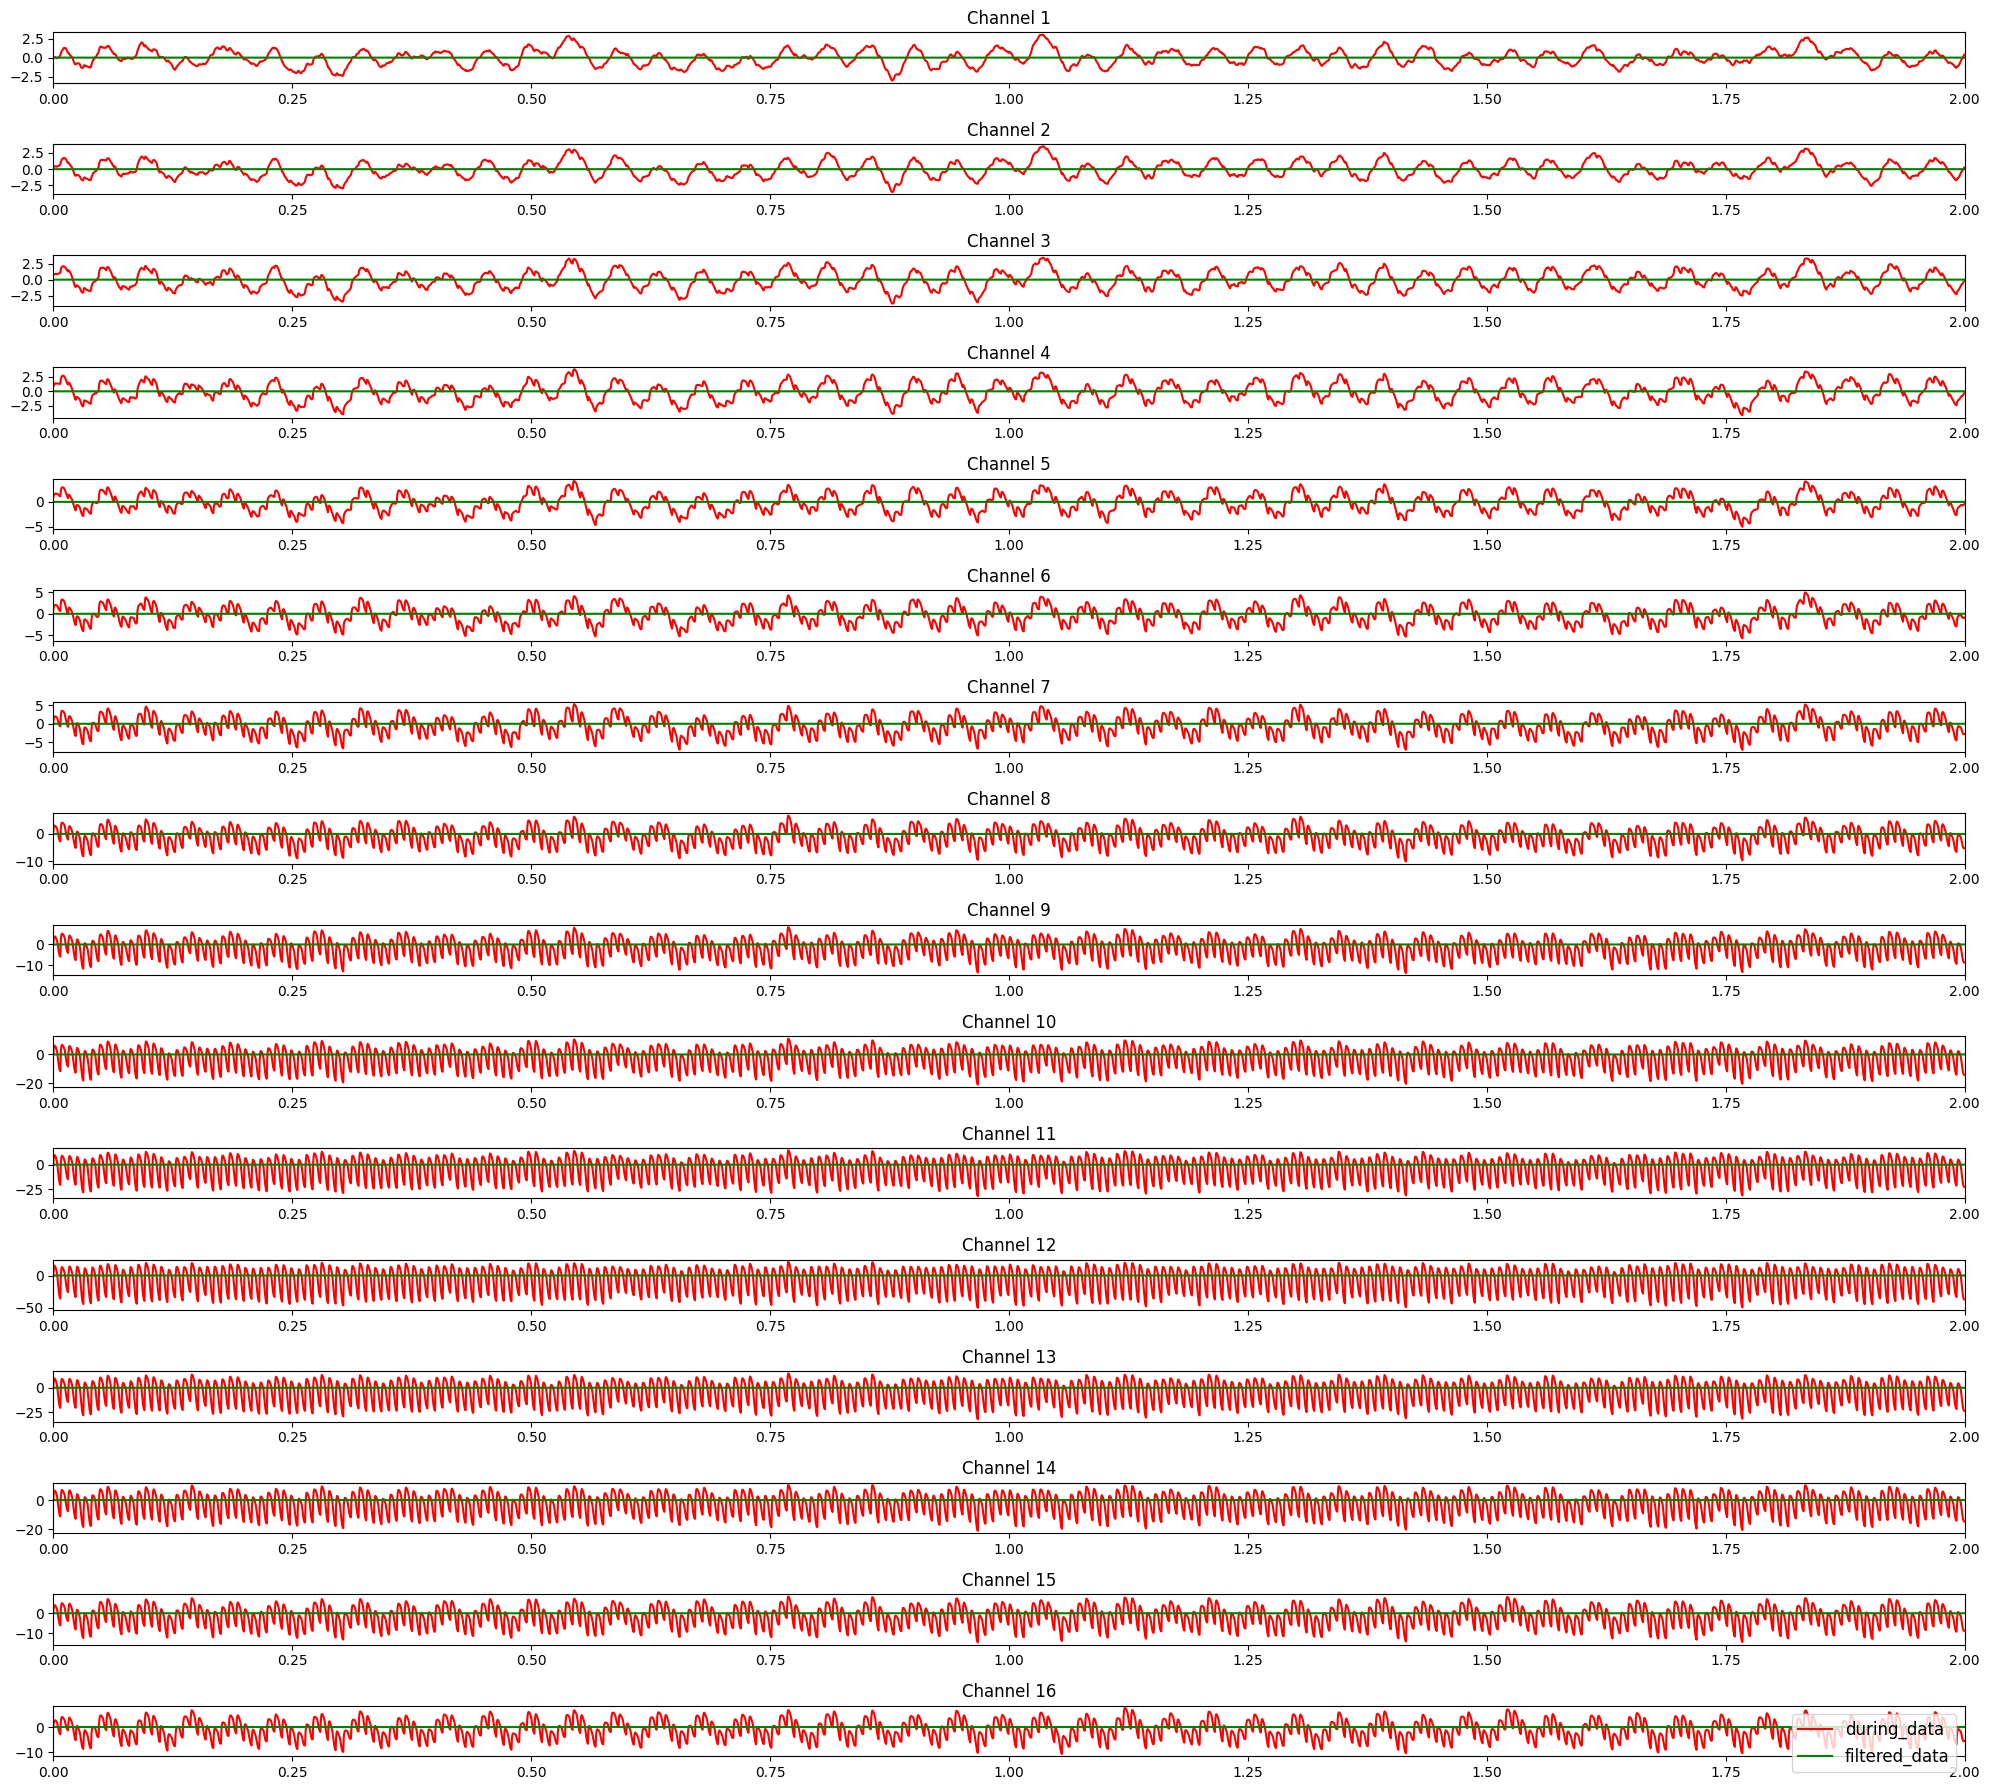

In [82]:
# 결과 출력 - 전체 채널
plt.figure(figsize=(20, 18))
for i in range(n_channels):
    plt.subplot(n_channels, 1, i+1)
    plt.plot(time, during_data[i, :], 'r', label='during_data')
    plt.plot(time, filtered_data[i, :], 'g', label='filtered_data')
    plt.xlim(0, 2)
    plt.title(f'Channel {i+1}')
    
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

In [76]:
### Method 2 - NLMS (Normalized Least-Mean-Squares)

def nlms_filter(desired, noise, mu, epsilon, n_iterations):
    """
    NLMS Adaptive Filter.
    desired: desired signal (d(n))
    noise: noise signal (x(n))
    mu: step size (learning rate)
    epsilon: small constant to avoid division by zero
    n_iterations: number of iterations (filter length)
    """
    n = n_iterations
    w = np.zeros(n)  # Filter weights
    output = np.zeros(len(desired))
    error = np.zeros(len(desired))

    for i in range(n, len(desired)):
        x = noise[i:i - n:-1]  # Input segment
        norm_x = np.dot(x, x)  # Energy of input segment
        if norm_x == 0:
            norm_x = epsilon  # Avoid division by zero
        output[i] = np.dot(w, x)
        error[i] = desired[i] - output[i]
        w = w + (mu / (epsilon + norm_x)) * error[i] * x

    return output, error, w

# parameters
n_iterations = 32
mu = 0.001  # Step size
epsilon = 1e-6  # Small constant to avoid division by zero

stimulus_signal = during_data[stim_ch, :]
target_signal = during_data[target_ch, :]

# Apply NLMS filter to each channel
filtered_data = np.zeros((n_channels, n_samples))
for i in range(n_channels):
    filtered_data[i, :], _, _ = nlms_filter(stimulus_signal, target_signal, mu, epsilon, n_iterations)


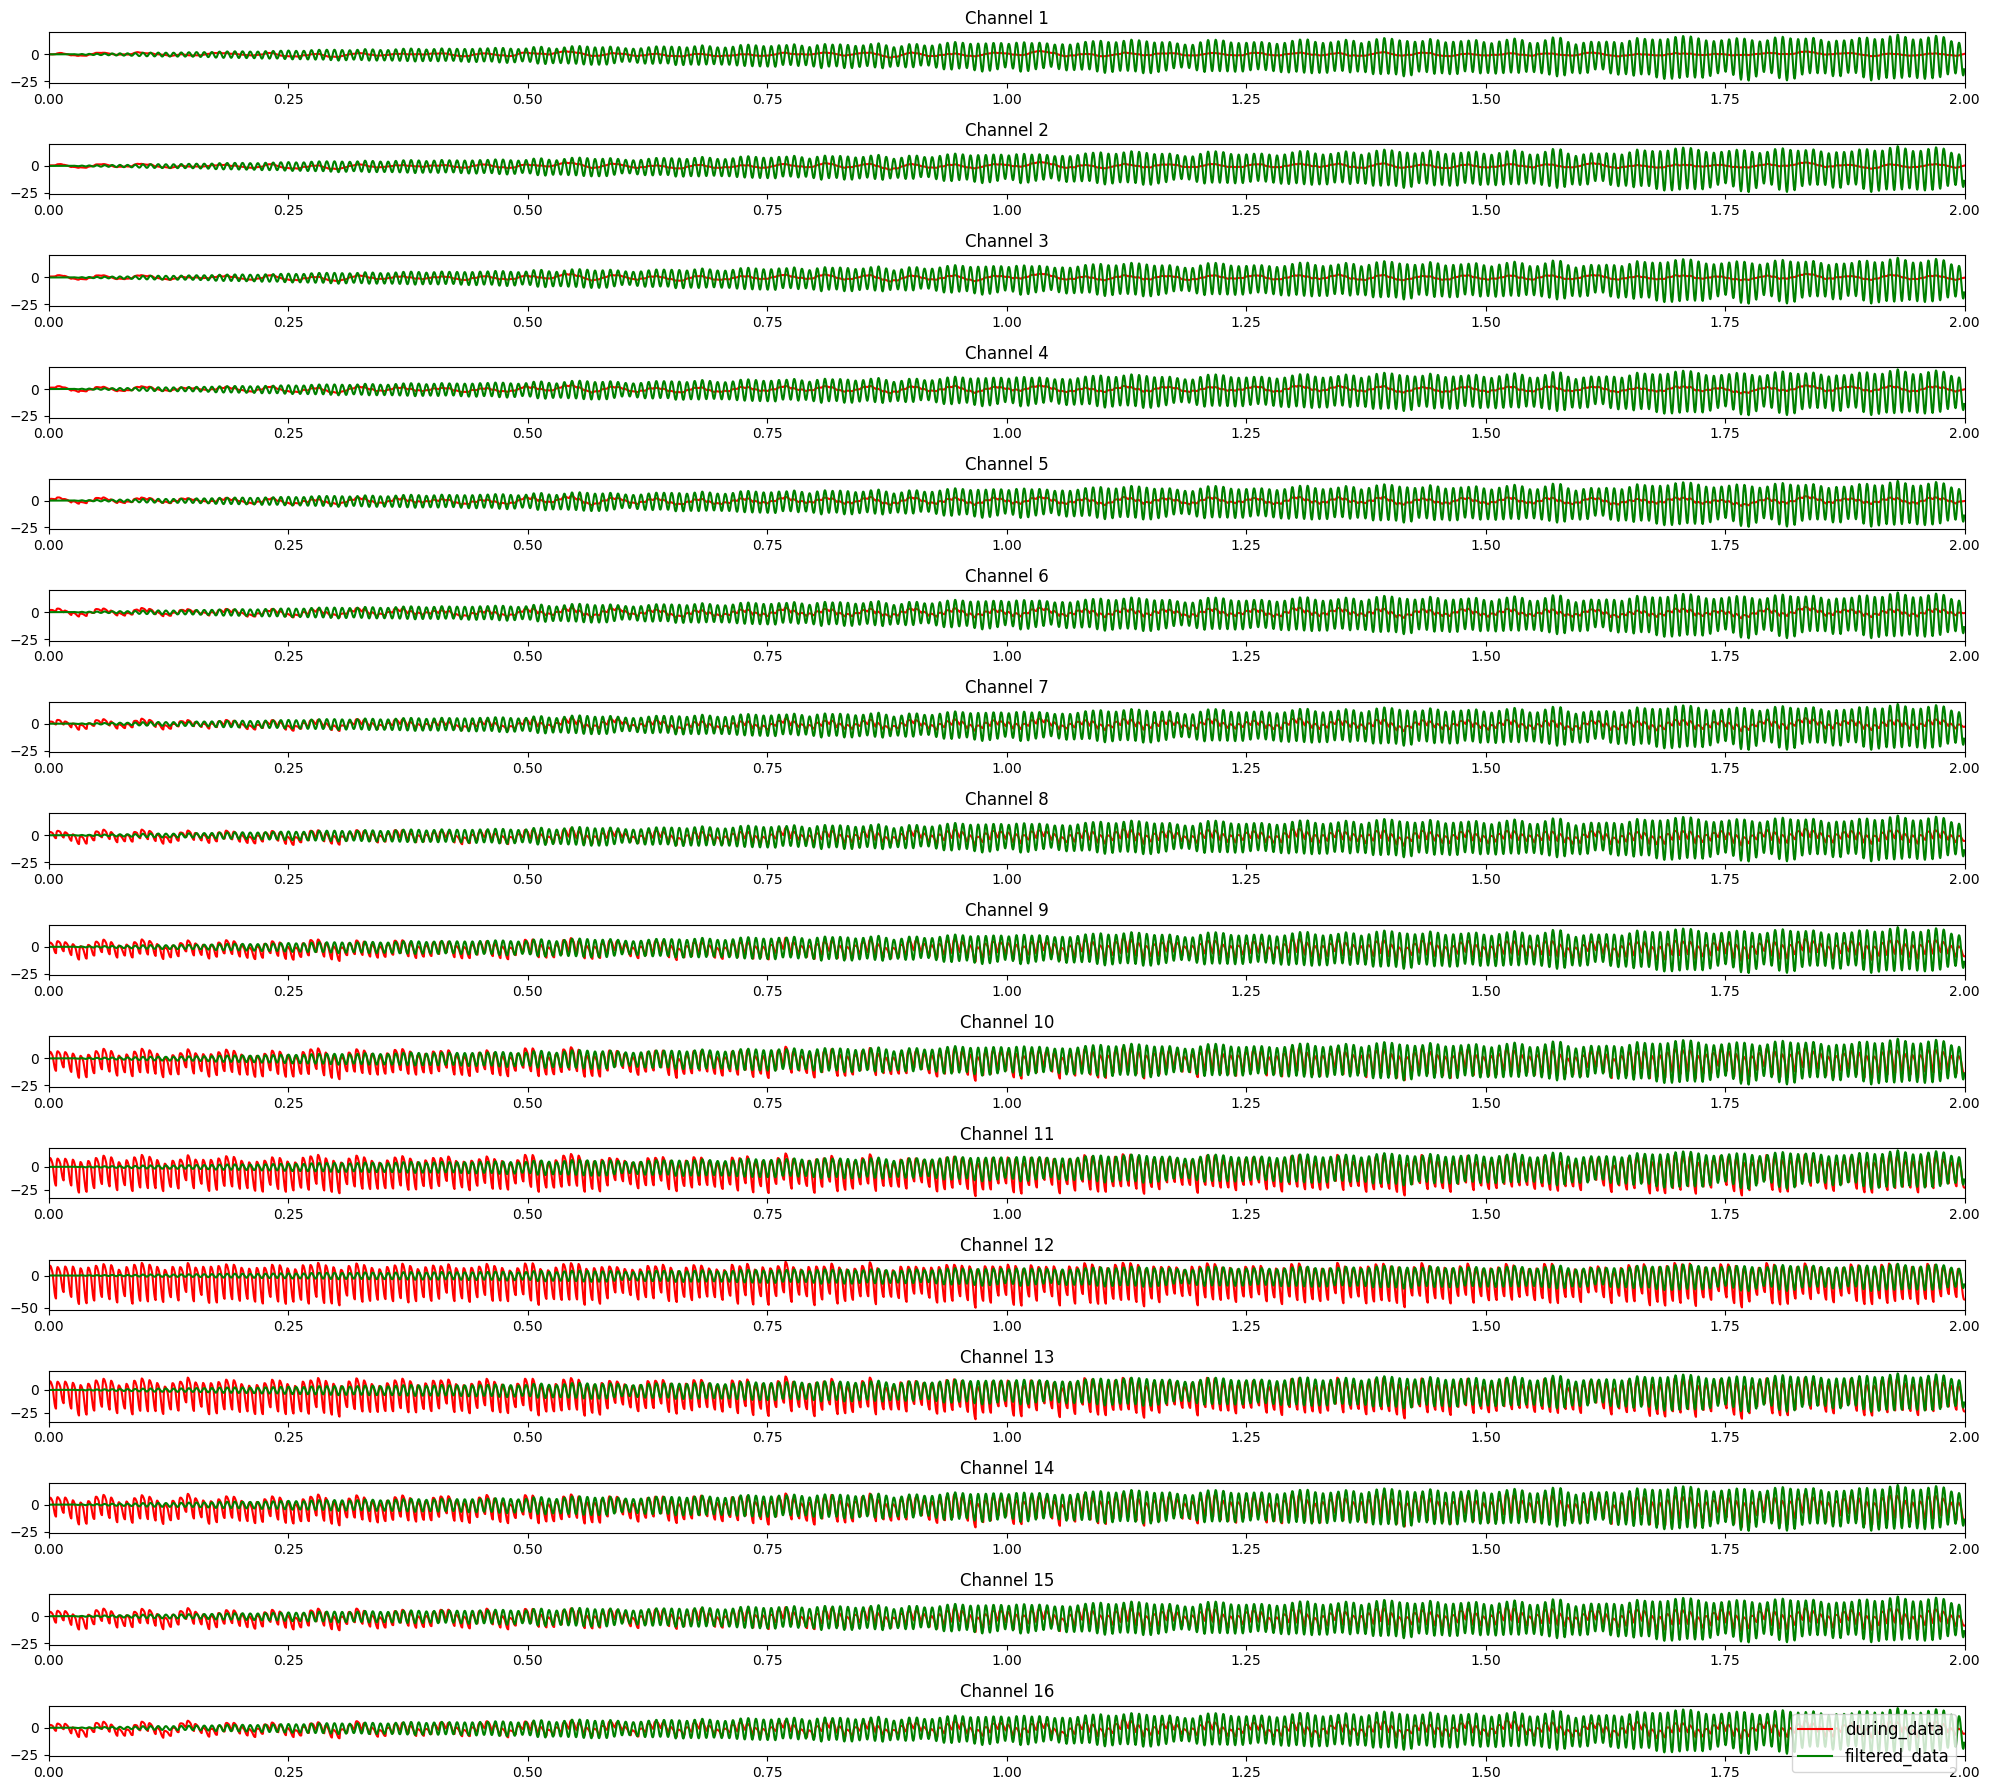

In [77]:
# 결과 출력 - 전체 채널
plt.figure(figsize=(20, 18))
for i in range(n_channels):
    plt.subplot(n_channels, 1, i+1)
    plt.plot(time, during_data[i, :], 'r', label='during_data')
    plt.plot(time, filtered_data[i, :], 'g', label='filtered_data')
    plt.xlim(0, 2)
    plt.title(f'Channel {i+1}')
    
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

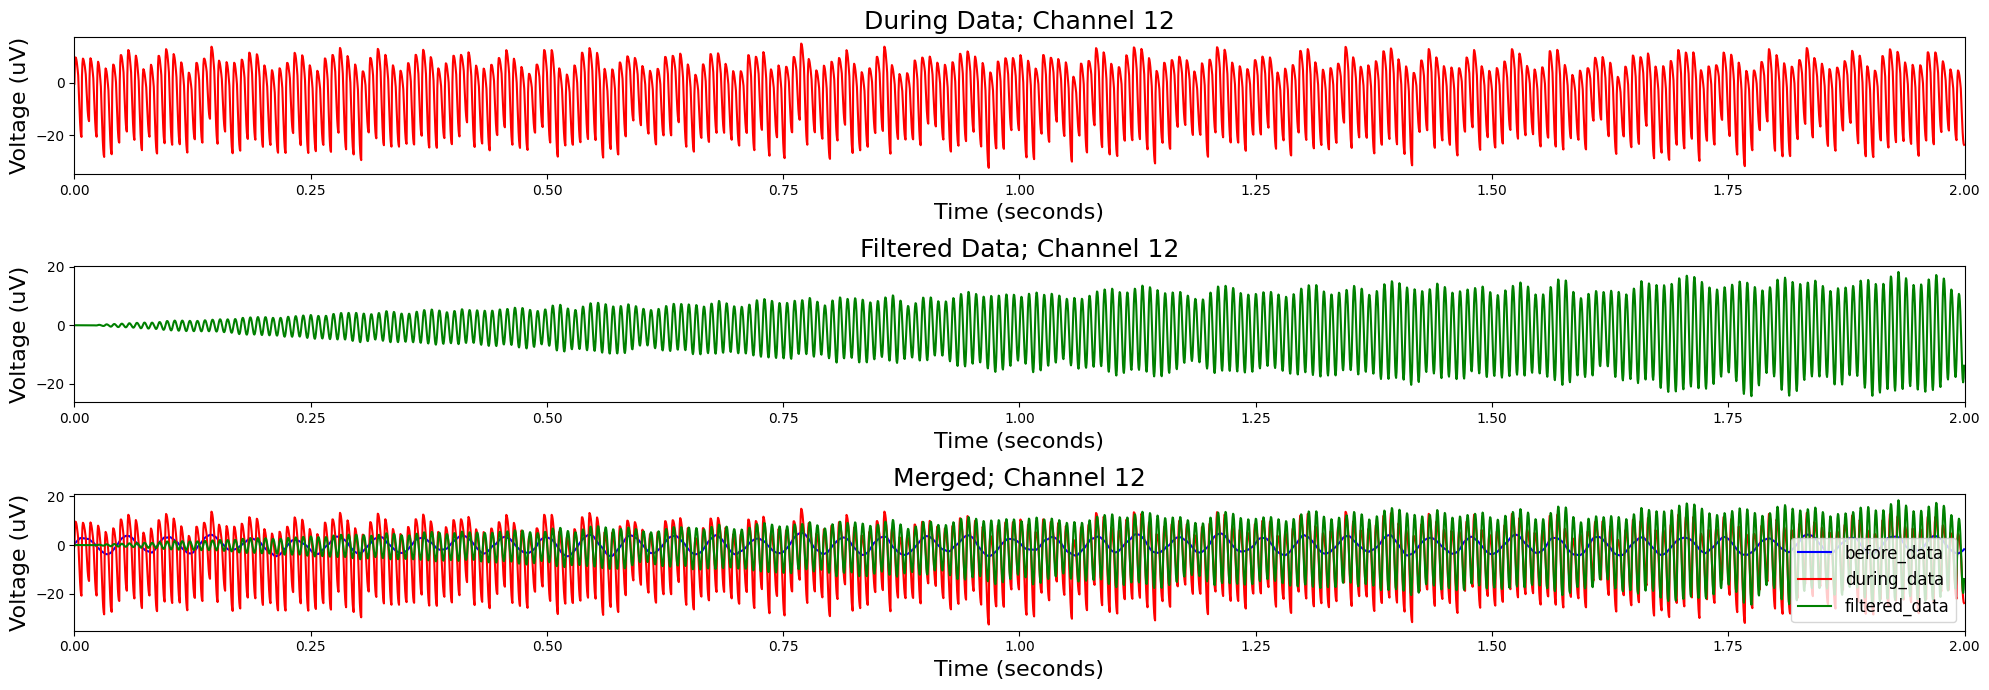

In [78]:
# 결과 플로팅 - 내가 볼 채널만
plt.figure(figsize=(20, 7))

# 원본 데이터
plt.subplot(3, 1, 1)
plt.plot(time, during_data[target_ch, :], 'r')
plt.xlim(0, 2)
plt.xlabel("Time (seconds)", fontsize=16)
plt.ylabel('Voltage (uV)', fontsize=16)
plt.title(f'During Data; Channel {target_ch}', fontsize=18)

# 필터된 데이터
plt.subplot(3, 1, 2)
plt.plot(time, filtered_data[target_ch, :], 'g')
plt.xlim(0, 2)
plt.xlabel("Time (seconds)", fontsize=16)
plt.ylabel('Voltage (uV)', fontsize=16)
plt.title(f'Filtered Data; Channel {target_ch}', fontsize=18)

# Time domain
plt.subplot(3, 1, 3)
plt.plot(time, before_data[target_ch, :], 'b', label='before_data')
plt.plot(time, during_data[target_ch, :], 'r', label='during_data')
plt.plot(time, filtered_data[target_ch, :], 'g', label='filtered_data')
plt.xlim(0, 2)
plt.xlabel("Time (seconds)", fontsize=16)
plt.ylabel('Voltage (uV)', fontsize=16)
plt.title(f'Merged; Channel {target_ch}', fontsize=18)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

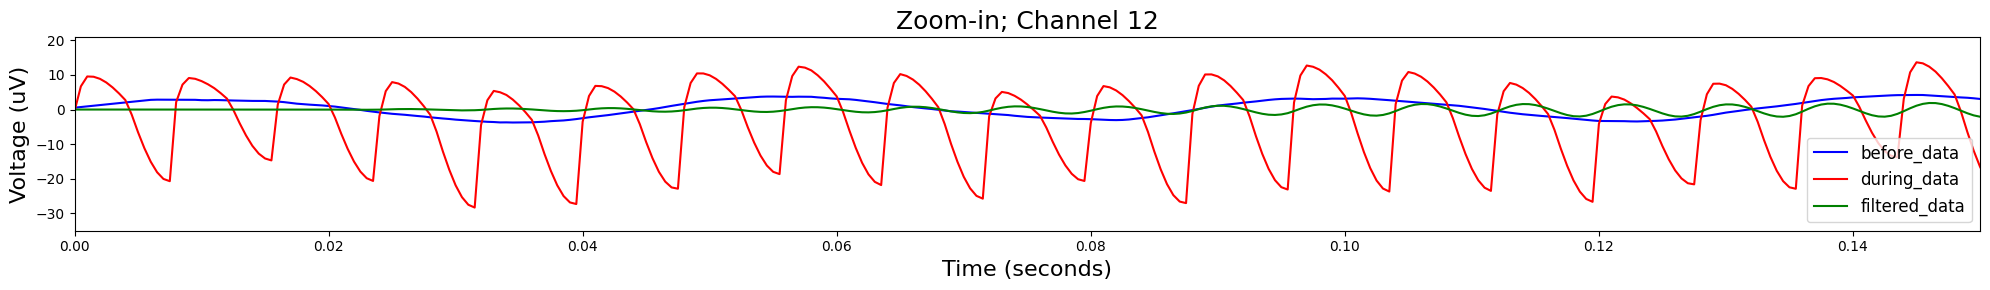

In [79]:
# 결과 플로팅 - 줌인
plt.figure(figsize=(20, 3))

start_t = 0
end_t = 0.15

plt.plot(time, before_data[target_ch, :], 'b', label='before_data')
plt.plot(time, during_data[target_ch, :], 'r', label='during_data')
plt.plot(time, filtered_data[target_ch, :], 'g', label='filtered_data')
plt.xlim(start_t, end_t)
plt.xlabel("Time (seconds)", fontsize=16)
plt.ylabel('Voltage (uV)', fontsize=16)
plt.title(f'Zoom-in; Channel {target_ch}', fontsize=18)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

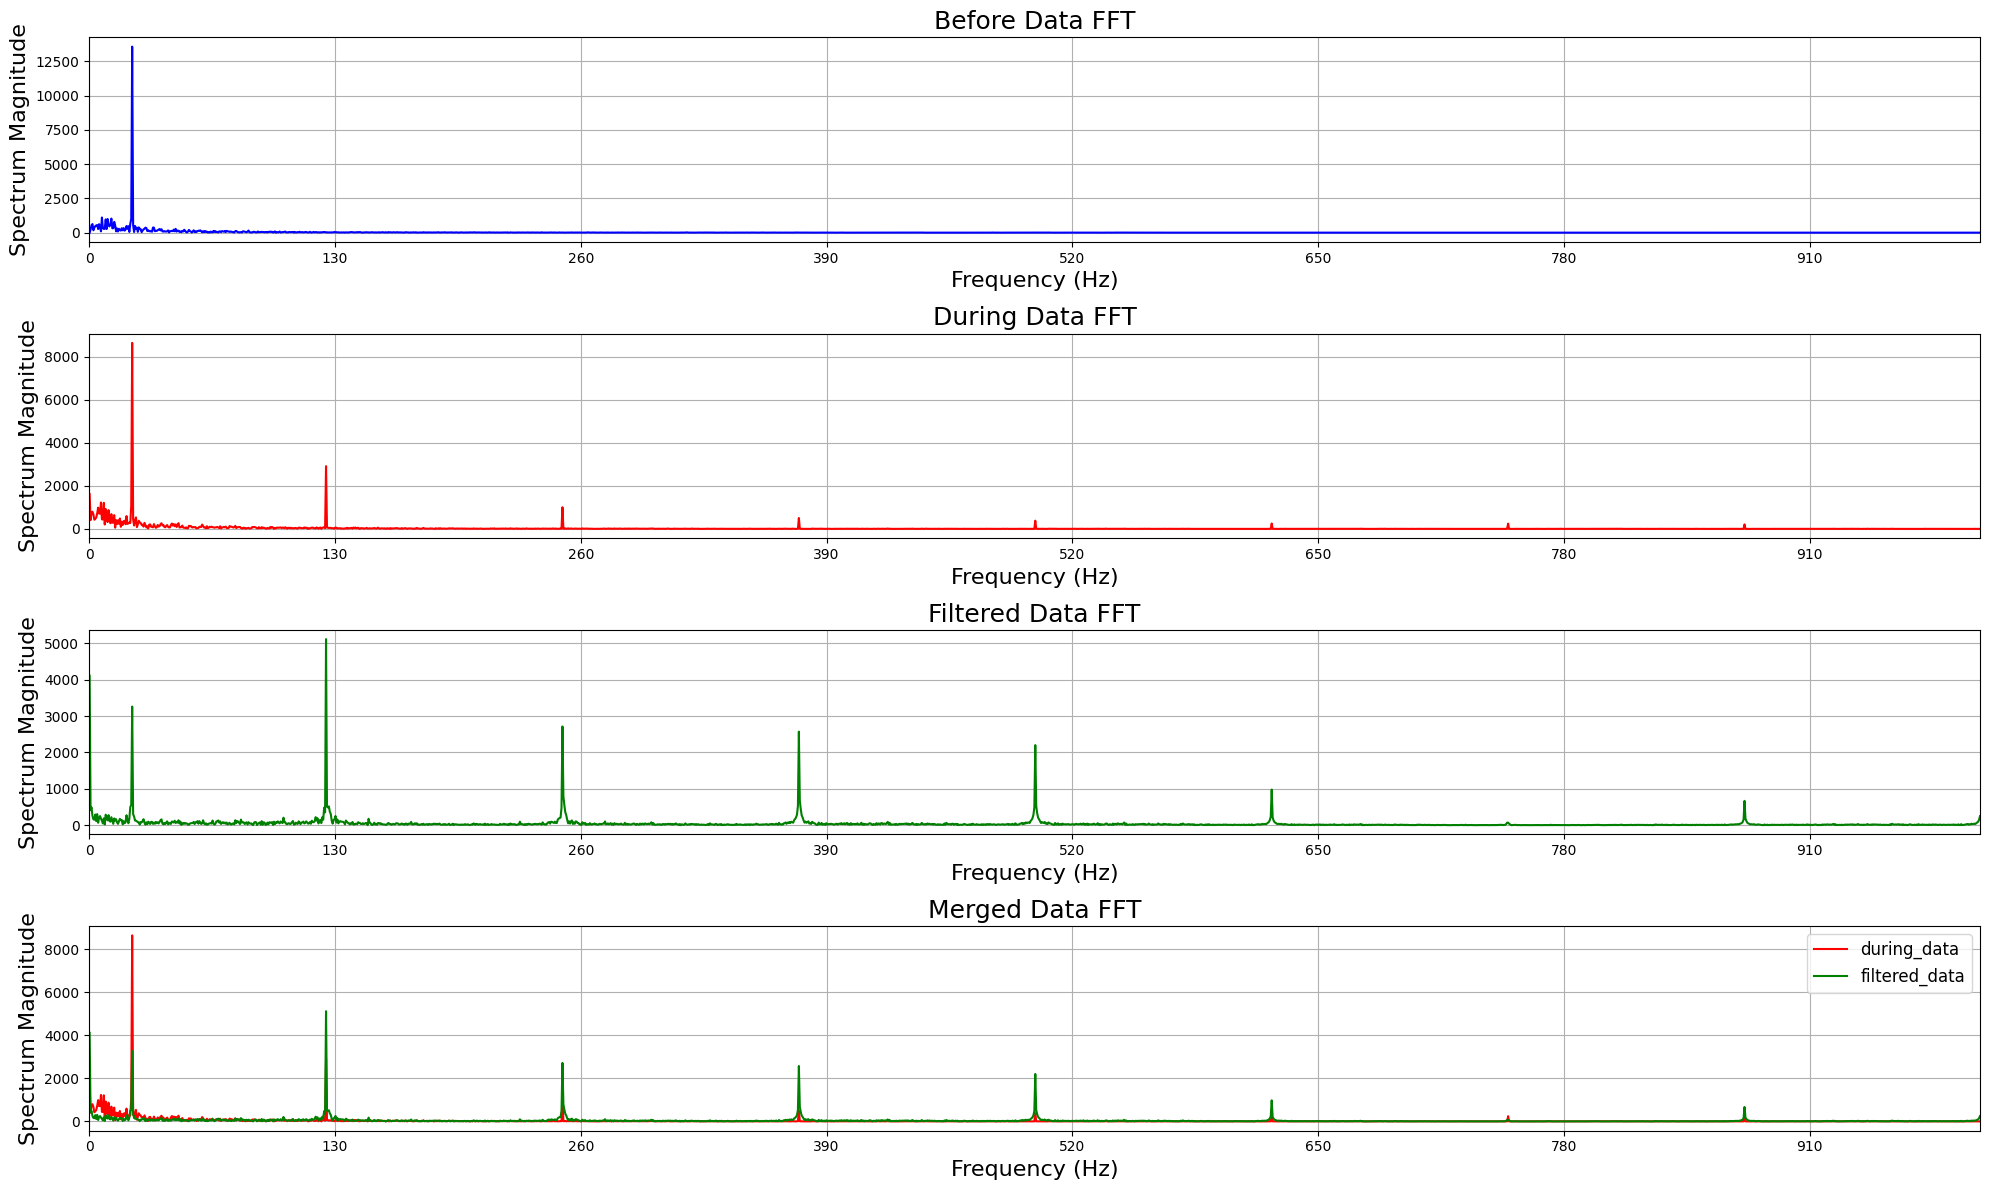

In [80]:
# 푸리에 변환 수행
before_fft_result = np.fft.fftshift(np.fft.fft(before_data, axis=1), axes=1)
during_fft_result = np.fft.fftshift(np.fft.fft(during_data, axis=1))
car_fft_result = np.fft.fftshift(np.fft.fft(filtered_data, axis=1))
acar_fft_result = np.fft.fftshift(np.fft.fft(acar_filtered_data, axis=1))

# 양수 부분의 주파수와 푸리에 변환 결과 가져오기
positive_frequencies = frequencies[n_samples // 2:]
positive_before_fft_result = 2 * before_fft_result[:, n_samples//2:]
positive_during_fft_result = 2 * during_fft_result[:, n_samples // 2:]
positive_car_fft_result = 2 * car_fft_result[:, n_samples // 2:]
positive_acar_fft_result = 2 * acar_fft_result[:, n_samples // 2:]

# 푸리에 스펙트럼 플로팅
plt.figure(figsize=(20, 12))

# 자극 전 데이터
plt.subplot(4, 1, 1)
plt.plot(positive_frequencies, np.abs(positive_before_fft_result[target_ch, :]), 'b', label='before_data')
plt.xlim([0, fs/2])
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('Spectrum Magnitude', fontsize=16)
plt.title('Before Data FFT', fontsize=18)
plt.grid()
plt.gca().set_xticks(np.arange(0, positive_frequencies[-1], 130))

# 원본 데이터
plt.subplot(4, 1, 2)
plt.plot(positive_frequencies, np.abs(positive_during_fft_result[target_ch, :]), 'r', label='during_data')
plt.xlim([0, fs/2])
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('Spectrum Magnitude', fontsize=16)
plt.title('During Data FFT', fontsize=18)
plt.grid()
plt.gca().set_xticks(np.arange(0, positive_frequencies[-1], 130))

# 필터된 데이터
plt.subplot(4, 1, 3)
plt.plot(positive_frequencies, np.abs(positive_acar_fft_result[target_ch, :]), 'g', label='filtered_data')
plt.xlim([0, fs/2])
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('Spectrum Magnitude', fontsize=16)
plt.title('Filtered Data FFT', fontsize=18)
plt.grid()
plt.gca().set_xticks(np.arange(0, positive_frequencies[-1], 130))

# Freq. domain
plt.subplot(4, 1, 4)
plt.plot(positive_frequencies, np.abs(positive_during_fft_result[target_ch, :]), 'r', label='during_data')
plt.plot(positive_frequencies, np.abs(positive_acar_fft_result[target_ch, :]), 'g', label='filtered_data')
plt.xlim([0, fs/2])
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.ylabel('Spectrum Magnitude', fontsize=16)
plt.title('Merged Data FFT', fontsize=18)
plt.legend(fontsize=12)
plt.grid()
plt.gca().set_xticks(np.arange(0, positive_frequencies[-1], 130))

plt.tight_layout()
plt.show()

In [52]:
# 평가
print("Time domain")
mae_time = mean_absolute_error(during_data[target_ch, :], acar_filtered_data[target_ch, :])
mse_time = mean_squared_error(during_data[target_ch, :], acar_filtered_data[target_ch, :])
print(f"Mean Absolute Error: {mae_time:.4f}")
print(f"Mean Squared Error: {mse_time:.4f}")

print("\nFrequency domain")

dft_magnitude_during = np.abs(positive_during_fft_result)**2
dft_magnitude_filtered = np.abs(positive_acar_fft_result)**2

# 로그 변환: 0 값 처리
dft_magnitude_during[dft_magnitude_during <= 0] = np.finfo(float).eps
dft_magnitude_filtered[dft_magnitude_filtered <= 0] = np.finfo(float).eps

log_dft_magnitude_during = np.log10(dft_magnitude_during)
log_dft_magnitude_filtered = np.log10(dft_magnitude_filtered)

mae_freq = mean_absolute_error(log_dft_magnitude_during, log_dft_magnitude_filtered)
mse_freq = mean_squared_error(log_dft_magnitude_during, log_dft_magnitude_filtered)

print(f"Mean Absolute Error: {mae_freq:.4f}")
print(f"Mean Squared Error: {mse_freq:.4f}")

Time domain
Mean Absolute Error: 2.8893
Mean Squared Error: 14.5786

Frequency domain
Mean Absolute Error: 0.7762
Mean Squared Error: 1.1090
